<a href="https://colab.research.google.com/github/teoad95/Chest-Xray-prediction/blob/main/Football_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Football analytics using AI techniques</h1>
<p> </p>

In [31]:
import cv2
import torch
import pandas as pd
import numpy as np
import time
import os
from PIL import Image

In [20]:
%matplotlib inline

In [15]:
!git clone https://github.com/teoad95/Sport-analytics/

Cloning into 'Sport-analytics'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 98 (delta 2), reused 0 (delta 0), pack-reused 91
Unpacking objects: 100% (98/98), done.
Checking out files: 100% (21/21), done.


In [2]:
pip install pytube

##1 Generate dataset
For dataset generation (frame pictures) we created a function which given a youtube link, downloads the video and split it into frames every 0.5 sec.

In [3]:
from util_funs import get_frames_from_youtube_video
get_frames_from_youtube_video('https://www.youtube.com/watch?v=TeTQO5DgOXI')

Downloaded /content/Videos/Highlights Real Madrid vs FC Barcelona (2-1).mp4, in location Videos correctly!


In [4]:
image_location = '/content/Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame53.jpg'

##2 Detect players
For this task we used the pre-trained YOLO neural network.

In [5]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-7-6 torch 1.8.1+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding AutoShape... 


In [6]:
img = cv2.imread(image_location, cv2.IMREAD_COLOR)

In [9]:
from util_funs import plot_bb_on_img
import matplotlib.pyplot as plt

start_time = time.time()

# inference
results = model(img, size=640)  # includes NMS
boxes = results.pandas().xyxy[0]

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

# cv2.imshow("frame", cv2_img_bb)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print("--- %.2f seconds ---" % (time.time() - start_time))

--- 0.37 seconds ---


In [12]:
img = Image.open(image_location)

In [13]:
from PIL import Image
from util_funs import sliding_window
import math


fig = plt.figure(figsize=(25, 25))

#img = Image.open(image_location)
img_width, img_height = img.size
step_size= 64
window_size = (256,256)

columns = math.ceil(int(img_width / step_size))-3
rows = math.ceil(img_height / step_size)

ax = []

boxes_df = pd.DataFrame(columns = ['xmin','ymin','xmax','ymax','confidence','class','name','centerx','centery'])

start_time = time.time()

for i,(box,img) in enumerate(sliding_window(img, step_size, window_size)):
    ax.append(fig.add_subplot(rows, columns, i+1))
    # inference
    
    results = model(img, size=320)  # includes NMS
    boxes = results.pandas().xyxy[0]
    
  
    # plot bounding boxes
    cv2_img_bb = plot_bb_on_img(img, boxes)
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)
    plt.title(box)
    plt.imshow(cv2_img_bb)
    plt.axis('off')
    
    # project to starting image
    boxes.xmin = boxes.xmin+box[0]
    boxes.xmax = boxes.xmax+box[0]

    boxes.ymin = boxes.ymin+box[1]
    boxes.ymax = boxes.ymax+box[1]

    boxes['centerx'] = boxes.xmax - (boxes.xmax-boxes.xmin)/2
    boxes['centery'] = boxes.ymax - (boxes.ymax-boxes.ymin)/2
    boxes['distance'] = np.sqrt(boxes.centerx*boxes.centerx + boxes.centery*boxes.centery)
    
    boxes_df = boxes_df.append(boxes, ignore_index=True)
    
boxes_df = keep_unique_objects_df(boxes_df)

                
                
print("--- %.2f seconds ---" % (time.time() - start_time))

AttributeError: ignored

In [16]:
from util_funs import plot_bb_on_img, split_image_and_predict
import matplotlib.pyplot as plt

img = cv2.imread(image_location, cv2.IMREAD_COLOR)

boxes =  split_image_and_predict(img, model)

# plot bounding boxes
cv2_img_bb = plot_bb_on_img(img, boxes, tolerance=0.3)
cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(cv2_img_bb[:,:,::-1])

AttributeError: ignored

##3 Detect players and extract player object using RCNN

In [40]:
image_location2 = '/content/Images/Highlights Real Madrid vs FC Barcelona (2-1)/frame24.jpg'

In [17]:
RED_COLOR = np.array([255, 0, 0]) 
BLACK_COLOR = np.array([255, 255, 255]) 

<p>Load weights and Mask-RCNN configuration</p>

In [18]:
weightsPath = "/content/Sport-analytics/network_configuration/frozen_inference_graph.pb"
configPath = "/content/Sport-analytics/network_configuration/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] image size: 640x360 pixels


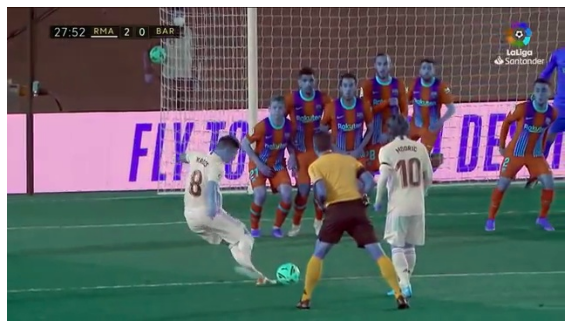

In [65]:
# load our input image and grab its spatial dimensions
image = cv2.imread(image_location2, cv2.IMREAD_UNCHANGED)
(H, W) = image.shape[:2]
print("[INFO] image size: {}x{} pixels".format(W, H))
from matplotlib import pyplot as plt
plt.figure(figsize=(10,30))
plt.imshow(image)
plt.axis('off')
plt.show()  

In [42]:
path = os.getcwd() + '/ImagesFromObject'
if not os.path.exists(path):
    os.mkdir(path)

In [43]:
# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()
# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] boxes size: {}".format(boxes.size))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 7.313691 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] boxes size: 700
[INFO] masks shape: (100, 90, 15, 15)


In [44]:
new_image = image

In [45]:
def plot_boxes(new_image):
	# loop over the number of detected objects
	for i in range(0, boxes.shape[2]):
		# extract the class ID of the detection along with the confidence
		# (i.e., probability) associated with the prediction
		classID = int(boxes[0, 0, i, 1])
		confidence = boxes[0, 0, i, 2]

		# filter out weak predictions by ensuring the detected probability
		# is greater than the minimum probability
		if confidence > 0.1:
			box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
			(startX, startY, endX, endY) = box.astype("int")
			boxW = endX - startX
			boxH = endY - startY
			mask = masks[i, classID]
			mask = cv2.resize(mask, (boxW, boxH), interpolation = cv2.INTER_NEAREST)
			mask1 = (mask > 1)
			_, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

			# extract the ROI of the image
			roi = new_image[startY:endY, startX:endX]
      ooi_height, ooi_width, _ = object_of_image.shape

			# now, extract *only* the masked region of the ROI by passing in the boolean mask array as our slice condition
			roi = roi[mask1]

			# Red will be used to visualize this particular instance segmentation 
			# then create a transparent overlay by blending the randomly selected color with the ROI
			blended = ((0.4 * RED_COLOR) + (0.6 * roi)).astype("uint8")

			# store the blended ROI in the original image
			new_image[startY:endY, startX:endX][mask1] = blended

			if (plot_boxes):
				# draw the bounding box of the instance on the image
				cv2.rectangle(new_image, (startX, startY), (endX, endY), (255,255,255), 2)

				# draw the predicted label and associated probability of the instance segmentation on the image
				text = "{}: {:.4f}".format("Person", confidence)
				cv2.putText(new_image, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

In [46]:
def extract_players(image):
    height, width , _ = image.shape
    cv2_img_bb = np.array(image) 
    # Convert RGB to BGR 
    cv2_img_bb = cv2.cvtColor(cv2_img_bb, cv2.bgr) 
    for i in range(boxes.shape[2]):
        box = boxes[0, 0 ,i]
        class_id = box[1]
        score = box[2]
        if (score < 0.5):
            continue
        # get box coordinates
        x = int(box[3] * width)
        y = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)

        object_of_image = image[y: y2, x: x2]
        ooi_height, ooi_width, _ = object_of_image.shape

        # get the mask
        mask = masks[i, int(class_id)]
        mask = cv2.resize(mask, (ooi_width, ooi_height))
        _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

        # convert mask to proper type in order to perform the bitwise_and
        visMask = (mask * 255).astype("uint8")

        # extract from box only the object for classification
        final = cv2.bitwise_and(object_of_image, object_of_image, mask = visMask)
        players.append(final)
        cv2.imwrite(path + "/person"+str(i)+".jpg", final)
        cv2.rectangle(cv2_img_bb, (x,y), (x2,y2), (255, 0, 0), 3)

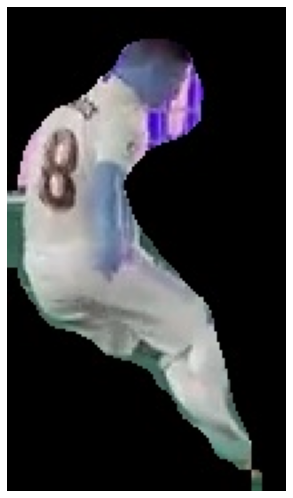

In [66]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,15))
plt.imshow(cv2.imread('/content/ImagesFromObject/person2.jpg', cv2.IMREAD_UNCHANGED))
plt.axis('off')
plt.show()  

In [52]:
players = []

In [47]:
plot_boxes(new_image)

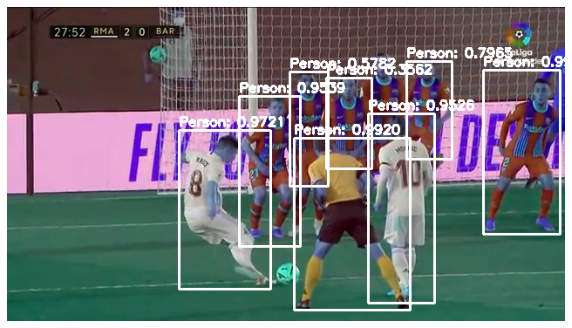

In [48]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,30))
plt.imshow(new_image)
plt.axis('off')
plt.show()  

In [53]:
extract_players(cv2.imread(image_location2, cv2.IMREAD_UNCHANGED))

##4 Classify players per team

For this task, kmeans will get used.
We'll find the average of the colors for each image and then we will cluster them in 2 centers.

In [58]:
from sklearn.cluster import KMeans

In [57]:
def extract_average_color(img):
    # calculate the average color of each row of our image
    avg_color_per_row = np.average(img, axis=0)

    # calculate the averages of our rows
    avg_colors = np.average(avg_color_per_row, axis=0)
    # so, convert that array to integers
    int_averages = np.array(avg_colors, dtype=np.uint8)
    return int_averages

In [60]:
features = [extract_average_color(player) for player in players]
clusters = KMeans(2, random_state= 40)
clusters.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=40, tol=0.0001, verbose=0)

In [67]:
image_with_players_classified = cv2.imread(image_location2, cv2.IMREAD_UNCHANGED)

In [122]:
def plot_boxes_with_predictions(new_image):
	# loop over the number of detected objects
	for i in range(0, boxes.shape[2]):
		# extract the class ID of the detection along with the confidence
		# (i.e., probability) associated with the prediction
		classID = int(boxes[0, 0, i, 1])
		confidence = boxes[0, 0, i, 2]

		# filter out weak predictions by ensuring the detected probability
		# is greater than the minimum probability
		if confidence > 0.5:
			box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
			(startX, startY, endX, endY) = box.astype("int")
			boxW = endX - startX
			boxH = endY - startY
			mask = masks[i, classID]
			mask = cv2.resize(mask, (boxW, boxH), interpolation = cv2.INTER_NEAREST)
			mask1 = (mask > 1)
			_, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

			# extract the ROI of the image
			roi = new_image[startY:endY, startX:endX]
			ooi_height, ooi_width, _ = roi.shape
			# now, extract *only* the masked region of the ROI by passing in the boolean mask array as our slice condition
			roi = roi[mask1]
			# get the mask
			mask = masks[i, int(classID)]
			mask = cv2.resize(mask, (ooi_width, ooi_height))
			_, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)

			# convert mask to proper type in order to perform the bitwise_and
			visMask = (mask * 255).astype("uint8")

			# extract from box only the object for classification
			final = cv2.bitwise_and(roi, roi, mask = visMask)

			# Red will be used to visualize this particular instance segmentation 
			# then create a transparent overlay by blending the randomly selected color with the ROI
			blended = ((0.4 * RED_COLOR) + (0.6 * roi)).astype("uint8")

			# store the blended ROI in the original image
			new_image[startY:endY, startX:endX][mask1] = blended
			color_to_use = (255,255,255)
			pred = clusters.predict(extract_average_color(final))
			if pred == 1:
				color_to_use = (255, 0, 0)
			if (plot_boxes):
				# draw the bounding box of the instance on the image
				cv2.rectangle(new_image, (startX, startY), (endX, endY), (255,255,255), 2)

				# draw the predicted label and associated probability of the instance segmentation on the image
				text = "{}: {:.4f}".format("Person", confidence)
				cv2.putText(new_image, text, (startX, startY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)

In [123]:
plot_boxes_with_predictions(image_with_players_classified)

error: ignored